# MNIST Preprocessing

**Joeri Hermans** (Technical Student, IT-DB-SAS, CERN)             
*Departement of Knowledge Engineering*         
*Maastricht University, The Netherlands*

In [1]:
!(date +%d\ %B\ %G)

17 January 2017


## Preparation

To get started, we first load all the required imports. Please make sure you installed dist-keras, and seaborn. Furthermore, we assume that you have access to an installation which provides Apache Spark.

Before you start this notebook, place the MNIST dataset (which is provided in this repository) on HDFS. Or in the case HDFS is not available, place it on the local filesystem. But make sure the path to the file is identical for all computing nodes.

In [2]:
%matplotlib inline

import numpy as np

import seaborn as sns

from pyspark import SparkContext
from pyspark import SparkConf

from matplotlib import pyplot as plt

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer

from distkeras.transformers import *
from distkeras.utils import *

Using TensorFlow backend.


In the following cell, adapt the parameters to fit your personal requirements.

In [3]:
# Modify these variables according to your needs.
application_name = "MNIST Preprocessing"
using_spark_2 = False
local = False
path = "data/mnist.csv"
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_processes = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 10
    num_processes = 2

In [4]:
# This variable is derived from the number of cores and executors, and will be used to assign the number of model trainers.
num_workers = num_executors * num_processes

print("Number of desired executors: " + `num_executors`)
print("Number of desired processes / executor: " + `num_processes`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 10
Number of desired processes / executor: 2
Total number of workers: 20


In [5]:
import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

In [6]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_processes`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "4g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [7]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
raw_dataset = reader.read.format('com.databricks.spark.csv') \
                    .options(header='true', inferSchema='true') \
                    .load(path)
raw_dataset = raw_dataset.repartition(num_workers)

As shown in the output of the cell above, we see that every pixel is associated with a seperate column. In order to ensure compatibility with Apache Spark, we vectorize the columns, and add the resulting vectors as a seperate column. However, in order to achieve this, we first need a list of the required columns. This is shown in the cell below.

In [8]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
features = raw_dataset.columns
features.remove('label')

Once we have a list of columns names, we can pass this to Spark's [VectorAssembler](http://spark.apache.org/docs/latest/ml-features.html#vectorassembler). This VectorAssembler will take a list of features, vectorize them, and place them in a column defined in `outputCol`.

In [9]:
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features" which will contain all the desired features aggregated into a single vector.
dataset = vector_assembler.transform(raw_dataset)

Once we have the inputs for our Neural Network (features column) after applying the VectorAssembler, we should also define the outputs. Since we are dealing with a classification task, the output of our Neural Network should be a one-hot encoded vector with 10 elements. For this, we provide a `OneHotTransformer` which accomplish this exact task.

In [10]:
# Define the number of output classes.
nb_classes = 10
encoder = OneHotTransformer(nb_classes, input_col="label", output_col="label_encoded")
dataset = encoder.transform(dataset)

## MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits. Every image is a 28 by 28 pixel grayscale image. This means that every pixel has a value between 0 and 255. Some examples of instances within this dataset are shown in the cells below.

In [11]:
def show_instances(column):
    global dataset

    num_instances = 6 # Number of instances you would like to draw.
    x_dimension   = 3 # Number of images to draw on the x-axis.
    y_dimension   = 2 # Number of images to draw on the y-axis.

    # Fetch 3 different instance from the dataset.
    instances = dataset.select(column).take(num_instances)
    # Process the instances.
    for i in range(0, num_instances):
        instance = instances[i]
        instance = instance[column].toArray().reshape((28, 28))
        instances[i] = instance

    # Draw the sampled instances.
    fig, axn = plt.subplots(y_dimension, x_dimension, sharex=True, sharey=True)
    num_axn = len(axn.flat)
    for i in range(0, num_axn):
        ax = axn.flat[i]
        h = sns.heatmap(instances[i], ax=ax)
        h.set_yticks([])
        h.set_xticks([])

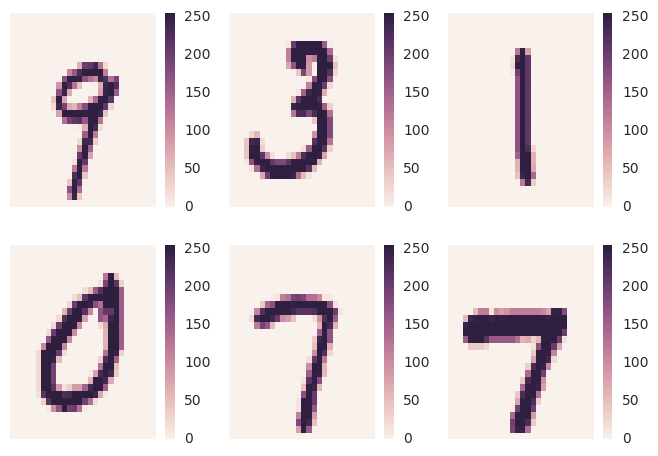

In [12]:
# Show an example before the features are preprocessed.
show_instances("features")

## Normalization

In this Section, we will normalize the feature vectors between the 0 and 1 range.

In [13]:
# Clear the dataset in the case you ran this cell before.
dataset = dataset.select("features", "label", "label_encoded")
# Allocate a MinMaxTransformer using Distributed Keras.
# o_min -> original_minimum
# n_min -> new_minimum
transformer = MinMaxTransformer(n_min=0.0, n_max=1.0, \
                                o_min=0.0, o_max=250.0, \
                                input_col="features", \
                                output_col="features_normalized")
# Transform the dataset.
dataset = transformer.transform(dataset)

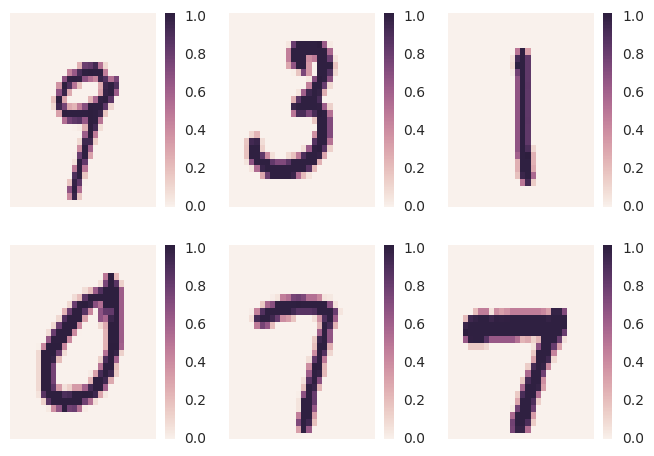

In [14]:
show_instances("features_normalized")

## Convolutions

In order to make the dense vectors compatible with convolution operations in Keras, we add another column which contains the matrix form of these images. We provide a utility class (MatrixTransformer), which helps you with this.

In [15]:
reshape_transformer = ReshapeTransformer("features_normalized", "matrix", (28, 28, 1))
dataset = reshape_transformer.transform(dataset)

## Dense Transformation

At the moment, dist-keras does not support SparseVectors due to the numpy dependency. As a result, we have to convert the SparseVector to a DenseVector. We added a simple utility transformer which does this for you.

In [16]:
dense_transformer = DenseTransformer(input_col="features_normalized", output_col="features_normalized_dense")
dataset = dense_transformer.transform(dataset)

## Artificial Enlargement

We want to make the dataset 100 times larger to simulate larger datasets, and to evaluate optimizer performance.

In [17]:
# Print the current number of instances in the dataset.
print("Number of instances: " + str(dataset.count()))

Number of instances: 42000


In [18]:
df = dataset
expansion = 100
for i in range(0, expansion):
    df = df.unionAll(dataset)
dataset = df
dataset.cache()

DataFrame[features: vector, label: bigint, label_encoded: vector, features_normalized: vector, matrix: array<array<array<double>>>, features_normalized_dense: vector]

In [19]:
# Print the number of instances after applying the artificial enlargement.
print("Number of instances: " + str(dataset.count()))

Number of instances: 4242000


## Writing to HDFS

In order to prevent constant preprocessing, and ensure optimizer performance, we write the data to HDFS in a Parquet format.

In [20]:
dataset.write.parquet("mnist.parquet")